# Calculating and analysing image edges

The simpest way to find edges in an image is uding gradients. A gradient shows us, how the intensity of colour changes on image between two neighbouring pixels.

We can run through the image and subtract every pixel from the neighbouring pixel. But it is much more efficient to do this using a convolution operation using a kernel like this:
$$\begin{bmatrix}-1 & 0 & 1\\-1 & 0 & 1\\-1 & 0 & 1\end{bmatrix}$$
which will effectively do the exactly same thing:

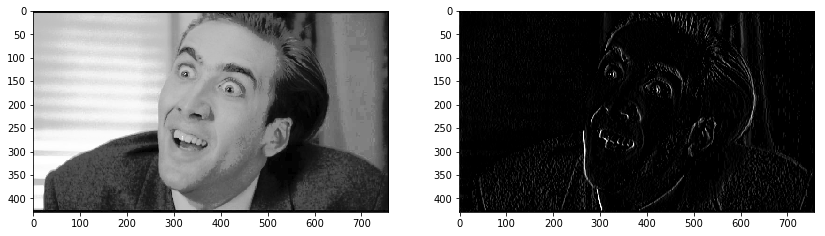

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("cage.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

height, width = gray.shape

gray = cv2.equalizeHist(gray)

kernel = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]], np.float32)
gradx = cv2.filter2D(gray, -1, kernel)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.subplot(122), plt.imshow(gradx, cmap='gray')
plt.show()

This is the x-Axis or a horizontal gradient. To calculatr the y-Axis (vertical) gradient we simply need to rotate the kernel:
$$\begin{bmatrix}-1 & -1 & -1\\0 & 0 & 0\\1 & 1 & 1\end{bmatrix}$$

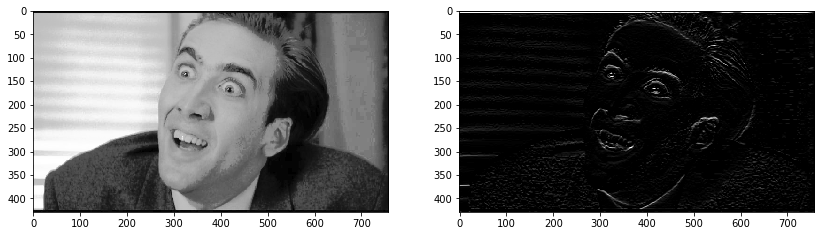

In [2]:
kernel = np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]], np.float32)
grady = cv2.filter2D(gray, -1, kernel)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.subplot(122), plt.imshow(grady, cmap='gray')
plt.show()

Now if we combine the two gradient images, we can get a vague idea about the edges in the image:

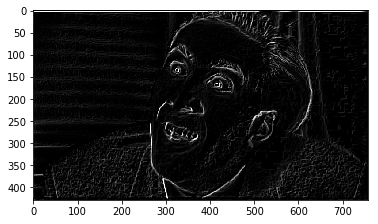

In [3]:
edges = cv2.add(gradx, grady)

plt.imshow(edges, cmap='gray')
plt.show()

The edges can be made more pronounced, if we threshold (binarize) the image:

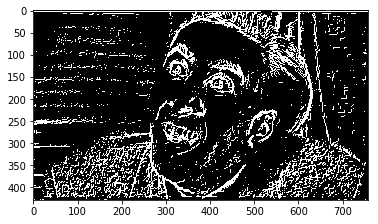

In [4]:
ret2,edges2 = cv2.threshold(edges, 20, 255,cv2.THRESH_BINARY)

plt.imshow(edges2, cmap='gray')
plt.show()

This is the basic idea behind the edge detection. Of course, the existing edge detection functions use more sophisticated algorithms and principles. Three of the most well known ones are: **Sobel operator**, **Laplacian derivative** and **Canny detector**.

## Sobel operator

Sobel operator is a more complex gradient operator, that uses a Gausssian smoothing along with the differentiation operation, so it is more resistant to noise. We can specify the direction of derivatives to be taken, vertical or horizontal (by the arguments, `yorder` and `xorder` respectively). We can also specify the size of kernel by the argument `ksize`.

The Sobel operator uses a slightly different kernel, to make sure that the edge is more visible:

<center>$kernel_x=\begin{bmatrix}-1 & 0 & 1\\-2 & 0 & 2\\-1 & 0 & 1\end{bmatrix}$ &nbsp;&nbsp;&nbsp; and &nbsp;&nbsp;&nbsp; $kernel_y=\begin{bmatrix}-1 & -2 & 1\\0 & 0 & 0\\1 & 2 & 1\end{bmatrix}$</center>

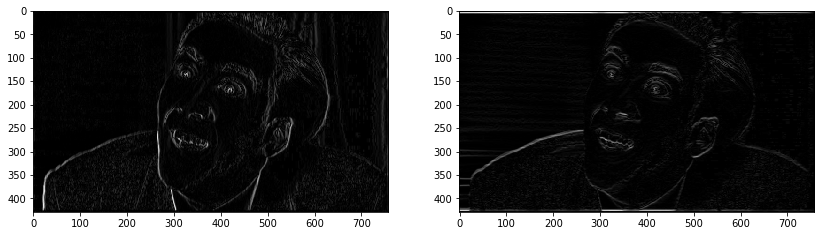

In [5]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(np.abs(sobelx), cmap='gray')
plt.subplot(122), plt.imshow(np.abs(sobely), cmap='gray')
plt.show()

## Laplacian derivative

It calculates the Laplacian of the image given by the relation, $\Delta src = \frac{\partial ^2{src}}{\partial x^2} + \frac{\partial ^2{src}}{\partial y^2}$ where each derivative is found using Sobel derivatives. If `ksize = 1`, then following kernel is used for filtering:
$$kernel=\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}$$

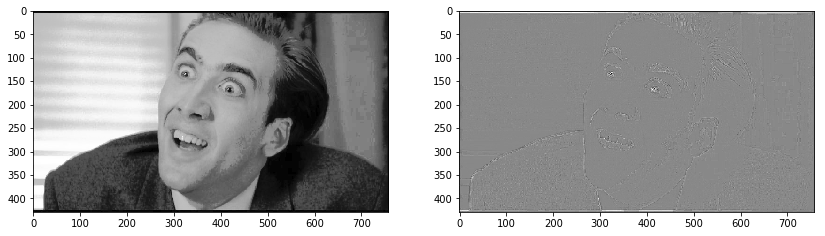

In [6]:
laplacian = cv2.Laplacian(gray, cv2.CV_64F)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.subplot(122), plt.imshow(laplacian, cmap='gray')
plt.show()

## Canny detector

Canny Edge Detection is a popular edge detection algorithm. It is a complex algorithm that consists of several stages:
1. Noise Reduction
2. Finding Intensity Gradient of the Image
3. Non-maximum Suppression
4. Hysteresis Thresholding

You can read more about the theory behind the Canny detector [here](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_canny/py_canny.html#canny) or [here](https://en.wikipedia.org/wiki/Canny_edge_detector).

OpenCV of course has an implementation of Canny edge detector which is a functionn `cv2.Canny()`. The first argument is our `input image`. Second and third arguments are our `minVal` and `maxVal` respectively. Third argument is `aperture_size`. It is the size of Sobel kernel used to find image gradients. By default it is 3. Last argument is `L2gradient` which specifies the equation for finding gradient magnitude.

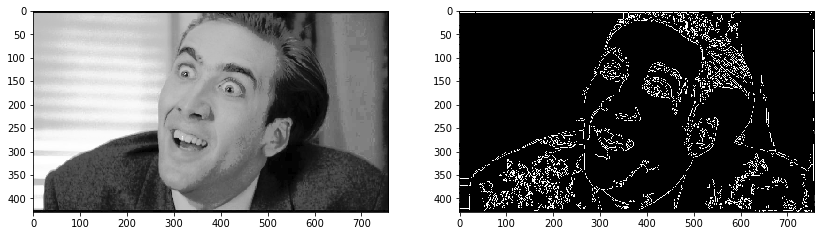

In [7]:
edges = cv2.Canny(gray,10,150)

plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.show()

## Fourier transform

We need to mention another, slightly more obscure way of detecting edges on an image, that is using the fast Fourier transform.

Fourier Transform is used to analyze the frequency characteristics of various filters. For images, **2D Discrete Fourier Transform** (DFT) is used to find the frequency domain. A fast algorithm called **Fast Fourier Transform** (FFT) is used for calculation of DFT. You can find some theoretican information about the Fourier transform [here](http://cns-alumni.bu.edu/~slehar/fourier/fourier.html).

Let's calculate the Fourier transform for Nicolas Cage:

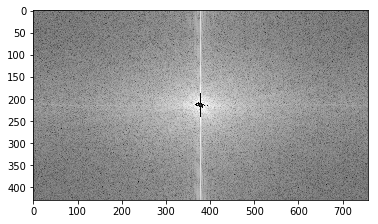

In [34]:
dft = cv2.dft(np.float32(gray),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

magnitude_spectrum = np.array(magnitude_spectrum[:,:], np.uint8)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()

An interesting thing we can do now is cut off some of the higher frequencies:

c:\python27\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


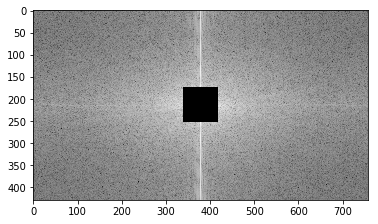

In [39]:
crow,ccol = height/2 , width/2

pc = 40 # how much to cut off

mask = np.ones((height,width,2),np.uint8)
mask[crow-pc:crow+pc, ccol-pc:ccol+pc] = 0

# apply mask
fshift = dft_shift * mask

# show the new spectrum:
magnitude_spectrum = 20*np.log(cv2.magnitude(fshift[:,:,0], fshift[:,:,1]))
magnitude_spectrum = np.array(magnitude_spectrum[:,:], np.uint8)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()

And now we can perform the inverse Fourier transform to get the original image, but without some of the frequencies:

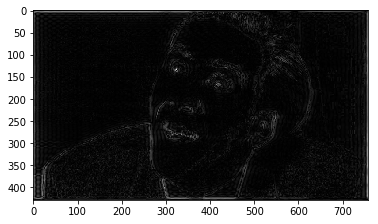

In [40]:
#inverse DFT
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img_back, cmap='gray')
plt.show()

Now, if instead we cut off some of the lower frequencies, the image will instead lose detail:

c:\python27\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


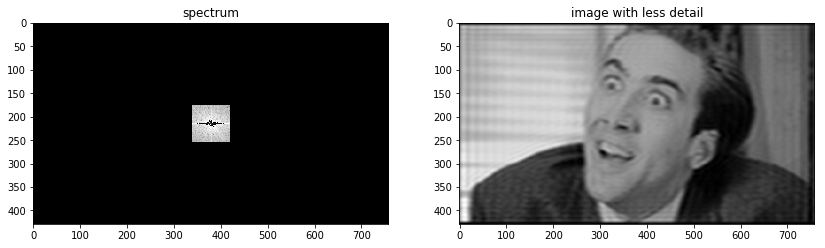

In [43]:
mask = np.zeros((height,width,2),np.uint8)
mask[crow-pc:crow+pc, ccol-pc:ccol+pc] = 1

# apply mask
fshift = dft_shift * mask

# show the new spectrum:
magnitude_spectrum = 20*np.log(cv2.magnitude(fshift[:,:,0], fshift[:,:,1]))
magnitude_spectrum = np.array(magnitude_spectrum[:,:], np.uint8)

#inverse DFT
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# show
plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title("spectrum")
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title("image with less detail")
plt.show()

# Hough transform

Hough Transform is a popular technique to detect any shape, if it can be represent in mathematical form. It can detect the shape even if it is broken or distorted a little bit.

Two of the most widely used applications for using Hough transform is finding straight lines and circles in an image.

## Hough line transform

A line can be represented as $y = mx+c$ or in parametric form, as $\rho = x \cos \theta + y \sin \theta$ where $\rho$ is the perpendicular distance from origin to the line, and $\theta$ is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise ( That direction varies on how you represent the coordinate system. This representation is used in OpenCV). Check below image:
![](https://docs.opencv.org/3.0-beta/_images/houghlines1.svg)
So if line is passing below the origin, it will have a positive rho and angle less than 180. If it is going above the origin, instead of taking angle greater than 180, angle is taken less than 180, and rho is taken negative. Any vertical line will have 0 degree and horizontal lines will have 90 degree.

Any line can be represented in these two terms, ($\rho$, $\theta$).

In **OpenCV** the Hough Line Transform is performed using the function `cv2.HoughLines()`. It simply returns an array of ($\rho$, $\theta$) values. $\rho$ is measured in pixels and $\theta$ is measured in radians. First parameter, Input image should be a binary image, so apply threshold or use canny edge detection before finding applying hough transform. Second and third parameters are $\rho$ and $\theta$ accuracies respectively. Fourth argument is the threshold, which means minimum vote it should get for it to be considered as a line. The number of votes depend upon number of points on the line. So it represents the minimum length of line that should be detected.

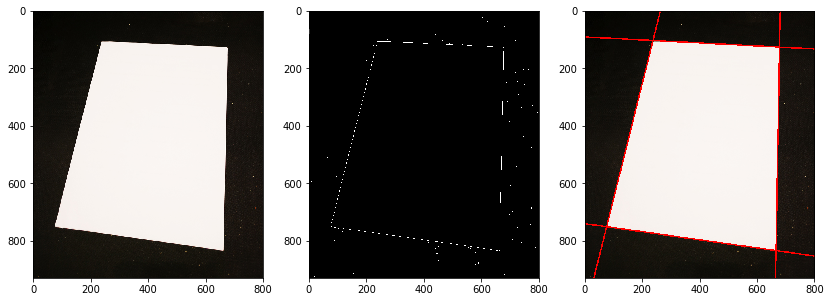

In [8]:
img = cv2.imread('paper.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

# show the original image
plt.subplots(figsize=(14, 10))
plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(132), plt.imshow(edges, cmap='gray')

# Perform the Hiugh Transform
lines = cv2.HoughLines(edges,1,np.pi/180,150)

# unpack the line parameters and draw them on the image
for line in lines:
    rho,theta = line[0]    
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),4)

# show the image with lines
plt.subplot(133), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Probabilistic Hough Transform

In the hough transform, you can see that even for a line with two arguments, it takes a lot of computation. Probabilistic Hough Transform is an optimization of Hough Transform. It doesn’t take all the points into consideration, instead take only a random subset of points and that is sufficient for line detection.

The **OpenCV** implementation of this transform is `cv2.HoughLinesP()`. It has two new arguments.
* `minLineLength` - Minimum length of line. Line segments shorter than this are rejected.
* `maxLineGap` - Maximum allowed gap between line segments to treat them as single line.

Instead of line parameters, this function directly returns the two endpoints of lines.

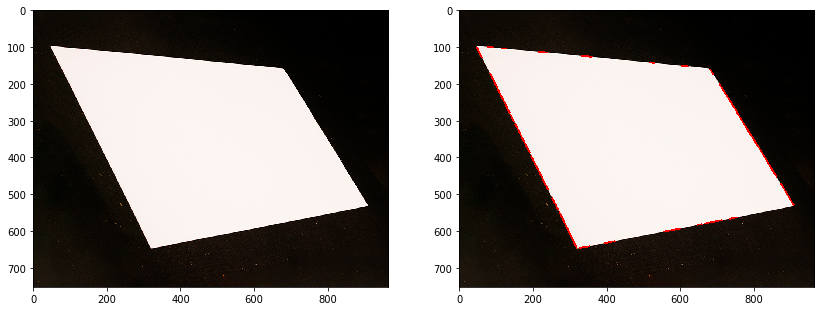

In [9]:
img = cv2.imread('paper2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

# show the original image
plt.subplots(figsize=(14, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

minLineLength = 100
maxLineGap = 10

lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength,maxLineGap)

for line in lines:    
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),4)
    
# show the image with lines
plt.subplot(122), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Lane detection on a road

Let's try to use everything we've learned up to now to try and find a lane in a video. This will be useful for creating an application for automatic car steering.

In [14]:
import lanes

video = cv2.VideoCapture("highway.mp4")

while True:
    ret, frame = video.read()
    
    if frame is None:
        break
    
    # convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # get image size
    height, width = gray.shape
    
    # find edges using Canny detector
    edges = cv2.Canny(gray, threshold1=200, threshold2=300)
    
    # cut off the top part of the image (we don't need it)
    mask = np.zeros_like(gray)
    cv2.rectangle(mask, (0, int(height*0.7)), (width-1, height-20), 255, -1)
    edges = cv2.bitwise_and(edges, mask)
    
    # blur the edges a bit for better detection
    edges = cv2.GaussianBlur(edges, (5, 5), 0)
    
    # do the Houg hTransform to get the lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 180, 50, 15)
        
    # locate and draw the lanes
    try:
        l1, l2 = lanes.draw_lanes(frame, lines)
        cv2.line(frame, (l1[0], l1[1]), (l1[2], l1[3]), [0, 255, 0], 20)
        cv2.line(frame, (l2[0], l2[1]), (l2[2], l2[3]), [0, 255, 0], 20)
    except Exception as e:        
        pass
            
    cv2.imshow("video", frame)
    
    key = cv2.waitKey(1) & 0xFF    
    if key == 27:
        break

video.release()
cv2.destroyAllWindows()